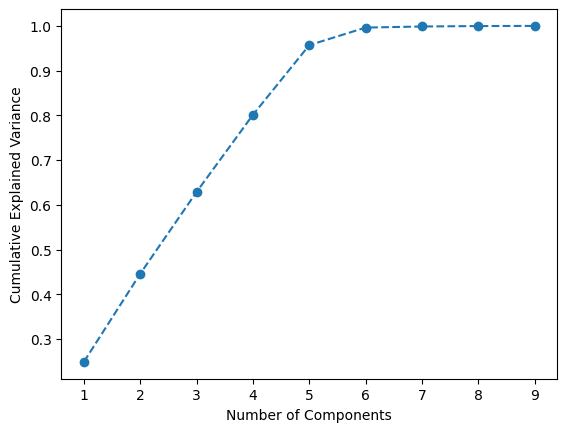

MSE before PCA: 2.0237268133623103
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
MSE after PCA: 0.015452526268653153


In [ ]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Load data
df = pd.read_csv('/content/vgsales.csv')

# Drop duplicates
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Select features și target variable
X = df.drop(['Global_Sales'], axis=1)
y = df['Global_Sales']

# Encode categorical variables using label encoding
categorical_features = X.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
X_encoded_categorical = X[categorical_features].apply(label_encoder.fit_transform)
X_encoded = pd.concat([X.select_dtypes(include=['number']), X_encoded_categorical], axis=1)

# Correlation analysis using Plotly Express
import plotly.express as px
correlation_matrix = X_encoded.corr()
fig = px.imshow(correlation_matrix)
fig.show()

# Apply PCA to handle correlation between 'NA_Sales' and 'EU_Sales'
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_encoded[['NA_Sales', 'EU_Sales']])
X_encoded['Sales_PCA'] = X_pca
X_encoded.drop(['NA_Sales', 'EU_Sales'], axis=1, inplace=True)

# New correlation analysis after dropping features and applying PCA
correlation_matrix_after_pca = X_encoded.corr()
fig_after_pca = px.imshow(correlation_matrix_after_pca)
fig_after_pca.show()

# Model preparation and split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Normalization through min-max scaling with imputation before PCA
scaler = MinMaxScaler()

# Impute missing values before scaling
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the data
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Explore number optim of components
pca = PCA()
pca.fit(X_train_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot Explained Variance
import matplotlib.pyplot as plt
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Choose the optimal number of components (ex 2) and apply PCA
optimal_n_components = 2
pca = PCA(n_components=optimal_n_components)
X_pca_optimal = pca.fit_transform(X_train_scaled)
X_test_pca_optimal = pca.transform(X_test_scaled)

# Model SVM before PCA
svm_model_before_pca = SVR()
svm_model_before_pca.fit(X_train_scaled, y_train)
y_pred_before_pca = svm_model_before_pca.predict(X_test_scaled)
mse_before_pca = mean_squared_error(y_test, y_pred_before_pca)
print(f"MSE before PCA: {mse_before_pca}")

# Model preparation and split data into training and testing sets after PCA
X_train_pca, X_test_pca, _, _ = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Normalization through min-max scaling with imputation after PCA
scaler = MinMaxScaler()

# Impute missing values before scaling
imputer = SimpleImputer(strategy='median')
X_train_imputed_pca = imputer.fit_transform(X_train_pca)
X_test_imputed_pca = imputer.transform(X_test_pca)

# Scale the data
X_train_scaled_pca = scaler.fit_transform(X_train_imputed_pca)
X_test_scaled_pca = scaler.transform(X_test_imputed_pca)

# Model SVM after PCA
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled_pca, y_train)

# Display the best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the model with the best parameters
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_scaled_pca, y_train)
y_pred_after_pca = best_svm_model.predict(X_test_scaled_pca)
mse_after_pca = mean_squared_error(y_test, y_pred_after_pca)
print(f"MSE after PCA: {mse_after_pca}")






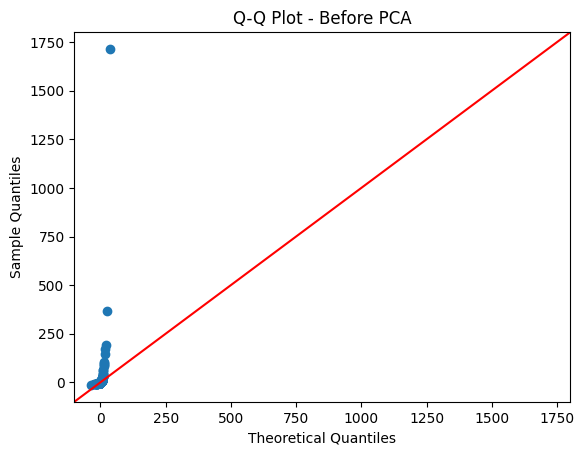

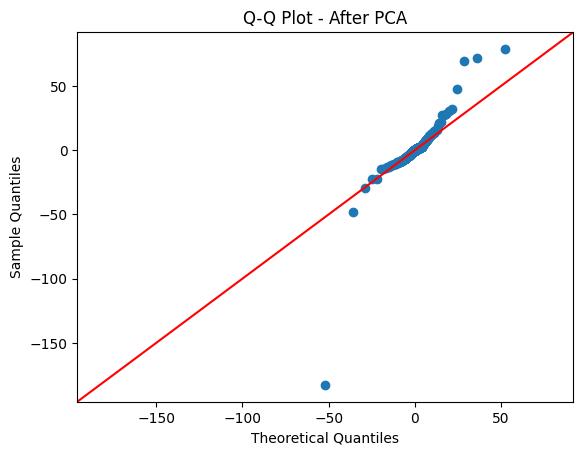

In [ ]:
import statsmodels.api as sm
import scipy.stats as stats

# Calculează reziduurile
residuals_before_pca = y_test - y_pred_before_pca
residuals_after_pca = y_test - y_pred_after_pca

# Diagrama Q-Q pentru reziduurile înainte de PCA
sm.qqplot(residuals_before_pca, stats.t, fit=True, line="45")
plt.title("Q-Q Plot - Before PCA")
plt.show()

# Diagrama Q-Q pentru reziduurile după PCA
sm.qqplot(residuals_after_pca, stats.t, fit=True, line="45")
plt.title("Q-Q Plot - After PCA")
plt.show()
